<a href="https://www.kaggle.com/code/derekxue/humanproteincell?scriptVersionId=141049098" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

#### Read through the following notebooks and links. Thanks all for their briliant ideas.

https://www.kaggle.com/c/hpa-single-cell-image-classification/discussion/221550 

https://www.kaggle.com/code/dragonzhang/fastai-cell-tile-prototyping-training/notebook  

https://www.kaggle.com/code/p4rallax/using-albumentations-with-fast-ai-datablock-api  

## Use fastai framework
## Load datasets, build dataloaders
## Use load_from_df
## Integrate albumentation. Use seamless augmentation. 

In [2]:
!pip install fastai -Uqq 

In [3]:
import pandas as pd
import numpy as np
import PIL.Image as Image
from fastai.data.all import *
from fastai.vision.all import *
from fastai.tabular.all import *

import albumentations as A

import warnings
# Ignore warning messages
warnings.filterwarnings("ignore")

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
protein_source = Path('/kaggle/input/hpa-single-cell-image-classification')

In [5]:
# build an image file meta data frame. 
%time
meta_df = pd.DataFrame({
    'image':(
        *get_image_files(protein_source),
    )
})

meta_df.head()

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 9.54 µs


,image
0,/kaggle/input/hpa-single-cell-image-classification/test/9b1d4b27-6946-4b86-a818-8e91029c3dfa_red.png
1,/kaggle/input/hpa-single-cell-image-classification/test/5af9bb81-719a-4374-9a12-5e5665329df6_blue.png
2,/kaggle/input/hpa-single-cell-image-classification/test/8adb17b7-ce2c-4721-bf34-c1806c72b4d4_yellow.png
3,/kaggle/input/hpa-single-cell-image-classification/test/c6379d83-6b05-4a29-8f56-05a381d94d2a_blue.png
4,/kaggle/input/hpa-single-cell-image-classification/test/277b3f6d-099b-4b6d-8592-a06ad6f52beb_red.png


In [6]:
# Get the parent folder name of each image path
image_paths = meta_df["image"].tolist()
parent_folder_names = []
for image_path in image_paths:
    parent_folder_name = os.path.dirname(image_path)
    label_value = parent_folder_name.split("/")[-1]
    parent_folder_names.append(label_value)

# Add the "trn_tst" column to the DataFrame
meta_df["trn_tst"] = parent_folder_names

# check for labels
meta_df['trn_tst'].value_counts()

train    87224
test      2236
Name: trn_tst, dtype: int64

### Get image id

In [7]:
def get_image_id(image_file): return str(image_file).split('_')[0]

In [8]:

meta_df['image_id'] = meta_df['image'].apply(get_image_id)

meta_df.head()

,image,trn_tst,image_id
0,/kaggle/input/hpa-single-cell-image-classification/test/9b1d4b27-6946-4b86-a818-8e91029c3dfa_red.png,test,/kaggle/input/hpa-single-cell-image-classification/test/9b1d4b27-6946-4b86-a818-8e91029c3dfa
1,/kaggle/input/hpa-single-cell-image-classification/test/5af9bb81-719a-4374-9a12-5e5665329df6_blue.png,test,/kaggle/input/hpa-single-cell-image-classification/test/5af9bb81-719a-4374-9a12-5e5665329df6
2,/kaggle/input/hpa-single-cell-image-classification/test/8adb17b7-ce2c-4721-bf34-c1806c72b4d4_yellow.png,test,/kaggle/input/hpa-single-cell-image-classification/test/8adb17b7-ce2c-4721-bf34-c1806c72b4d4
3,/kaggle/input/hpa-single-cell-image-classification/test/c6379d83-6b05-4a29-8f56-05a381d94d2a_blue.png,test,/kaggle/input/hpa-single-cell-image-classification/test/c6379d83-6b05-4a29-8f56-05a381d94d2a
4,/kaggle/input/hpa-single-cell-image-classification/test/277b3f6d-099b-4b6d-8592-a06ad6f52beb_red.png,test,/kaggle/input/hpa-single-cell-image-classification/test/277b3f6d-099b-4b6d-8592-a06ad6f52beb


In [9]:
# Check for unique image id in train dataset
meta_df[meta_df['trn_tst'] == 'train']['image_id'].nunique()

21806

In [10]:
# Check for unique image id in train dataset
meta_df[meta_df['trn_tst'] == 'test']['image_id'].nunique()

559

In [11]:
len(meta_df) / 4  #all images have R G B Yellow .png files

22365.0

In [12]:
#Reduce to a small set.

meta_df = meta_df[meta_df['trn_tst'] == 'train']
meta_small = meta_df.iloc[:400, :].copy()


In [13]:
def get_shape(image_file):
    image = Image.open(image_file)
    return image.shape

In [14]:
%time
meta_small['shape'] = meta_small['image'].apply(get_shape)
meta_small.head()

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 6.44 µs


,image,trn_tst,image_id,shape
2236,/kaggle/input/hpa-single-cell-image-classification/train/5e3a2e6a-bb9c-11e8-b2b9-ac1f6b6435d0_red.png,train,/kaggle/input/hpa-single-cell-image-classification/train/5e3a2e6a-bb9c-11e8-b2b9-ac1f6b6435d0,"(2048, 2048)"
2237,/kaggle/input/hpa-single-cell-image-classification/train/315a9edc-bbc6-11e8-b2bc-ac1f6b6435d0_yellow.png,train,/kaggle/input/hpa-single-cell-image-classification/train/315a9edc-bbc6-11e8-b2bc-ac1f6b6435d0,"(2048, 2048)"
2238,/kaggle/input/hpa-single-cell-image-classification/train/437fa1ce-bb9f-11e8-b2b9-ac1f6b6435d0_yellow.png,train,/kaggle/input/hpa-single-cell-image-classification/train/437fa1ce-bb9f-11e8-b2b9-ac1f6b6435d0,"(2048, 2048)"
2239,/kaggle/input/hpa-single-cell-image-classification/train/8a51782e-bb9b-11e8-b2b9-ac1f6b6435d0_green.png,train,/kaggle/input/hpa-single-cell-image-classification/train/8a51782e-bb9b-11e8-b2b9-ac1f6b6435d0,"(2048, 2048)"
2240,/kaggle/input/hpa-single-cell-image-classification/train/0df0c3aa-bbca-11e8-b2bc-ac1f6b6435d0_blue.png,train,/kaggle/input/hpa-single-cell-image-classification/train/0df0c3aa-bbca-11e8-b2bc-ac1f6b6435d0,"(2048, 2048)"


### Stack R, B, G, Yellow  


https://www.kaggle.com/datasets/philculliton/hpa-challenge-2021-extra-train-images/code  

In [15]:
import matplotlib.pyplot as plt
import cv2

from skimage.io import imsave, imread
import tqdm

In [16]:
meta_small.iloc[0, 2].split('/')[-1]  #demo

'5e3a2e6a-bb9c-11e8-b2b9-ac1f6b6435d0'

## Looking for way to put item transformation into GPU

In [17]:
%time
SZ = 2048
i=0
for iid in tqdm.tqdm(meta_small['image_id']):
    r = cv2.imread(f'{iid}_red.png', 0)
    g = cv2.imread(f'{iid}_green.png', 0)
    b = cv2.imread(f'{iid}_blue.png', 0)
    a = cv2.imread(f'{iid}_yellow.png', 0)
    if not r.shape[0] == SZ:
        r = cv2.resize(r, (SZ, SZ))
        g = cv2.resize(g, (SZ, SZ))
        b = cv2.resize(b, (SZ, SZ))
        a = cv2.resize(a, (SZ, SZ))
    img = np.stack([r, g, b, a], -1)
    fname = meta_small.iloc[i, 2].split('/')[-1]
    imsave(f'./{fname}_.png', img)
    i += 1

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 6.68 µs


100%|██████████| 400/400 [14:13<00:00,  2.13s/it]


In [18]:
# build an image file meta data frame. 
meta_sml_wk = pd.DataFrame({
    'image':(
        *get_image_files('/kaggle/working/'),
    )
})

meta_sml_wk.head()

,image
0,/kaggle/working/56a4a000-bbbe-11e8-b2ba-ac1f6b6435d0_.png
1,/kaggle/working/2363a9b0-bbb0-11e8-b2ba-ac1f6b6435d0_.png
2,/kaggle/working/98b92380-bbaf-11e8-b2ba-ac1f6b6435d0_.png
3,/kaggle/working/18a31752-bb9e-11e8-b2b9-ac1f6b6435d0_.png
4,/kaggle/working/32a672ee-bbb6-11e8-b2ba-ac1f6b6435d0_.png


In [19]:
def get_image_id_wk(image_file): 
    tmp = str(image_file).split('_')[0]
    return tmp.split('/')[-1]

In [20]:
meta_sml_wk['ID'] = meta_sml_wk['image'].apply(get_image_id_wk)

In [21]:
df_train = pd.read_csv('/kaggle/input/hpa-single-cell-image-classification/train.csv')
df_train.head()

,ID,Label
0,5c27f04c-bb99-11e8-b2b9-ac1f6b6435d0,8|5|0
1,5fb643ee-bb99-11e8-b2b9-ac1f6b6435d0,14|0
2,60b57878-bb99-11e8-b2b9-ac1f6b6435d0,6|1
3,5c1a898e-bb99-11e8-b2b9-ac1f6b6435d0,16|10
4,5b931256-bb99-11e8-b2b9-ac1f6b6435d0,14|0


In [22]:
df_merge = pd.merge(meta_sml_wk, df_train, left_on='ID', right_on='ID', how='outer')

In [23]:
df_merge = df_merge.dropna()

### Process label. Convert integer back to a string

https://www.kaggle.com/code/lnhtrang/hpa-public-data-download-and-hpacellseg/notebook  

In [24]:
# All label names in the public HPA and their corresponding index. Reduce the number of class into 19.
all_labels = {
    "Nucleoplasm": 0,
    "Nuclear membrane": 1,
    "Nucleoli": 2,
    "Nucleoli fibrillar center": 3,
    "Nuclear speckles": 4,
    "Nuclear bodies": 5,
    "Endoplasmic reticulum": 6,
    "Golgi apparatus": 7,
    "Intermediate filaments": 8,
#     "Actin filaments": 9,
    "Focal adhesion sites": 9,
    "Microtubules": 10,
    "Mitotic spindle": 11,
    "Centrosome": 12,
#     "Centriolar satellite": 12,
    "Plasma membrane": 13,
#     "Cell Junctions": 13,
    "Mitochondria": 14,
    "Aggresome": 15,
    "Cytosol": 16,
    "Vesicles": 17,
#     "Peroxisomes": 17,
#     "Endosomes": 17,
#     "Lysosomes": 17,
#     "Lipid droplets": 17,
#     "Cytoplasmic bodies": 17,
    "No staining": 18
}

In [25]:
all_labels.items()

dict_items([('Nucleoplasm', 0), ('Nuclear membrane', 1), ('Nucleoli', 2), ('Nucleoli fibrillar center', 3), ('Nuclear speckles', 4), ('Nuclear bodies', 5), ('Endoplasmic reticulum', 6), ('Golgi apparatus', 7), ('Intermediate filaments', 8), ('Focal adhesion sites', 9), ('Microtubules', 10), ('Mitotic spindle', 11), ('Centrosome', 12), ('Plasma membrane', 13), ('Mitochondria', 14), ('Aggresome', 15), ('Cytosol', 16), ('Vesicles', 17), ('No staining', 18)])

In [26]:
df_merge['Label']

0           2
1           9
2        16|0
3          16
4      16|5|0
        ...  
391         9
392         4
393     16|11
394        13
395     12|16
Name: Label, Length: 396, dtype: object

In [27]:
def g(df_merge):
    for i in range(len(df_merge)):
        label = df_merge.loc[i, 'Label']
        if '|' in label:
            df_merge.loc[i, 'Label'] = label.split('|')
        else:
            df_merge.loc[i, 'Label'] = label
    return df_merge

df_merge = g(df_merge.copy())
print(df_merge['Label'].head())

0             2
1             9
2       [16, 0]
3            16
4    [16, 5, 0]
Name: Label, dtype: object


In [28]:
df_merge['Label'][0]

'2'

In [29]:
df_list = []
for i in range(len(df_merge)):
  row_list = []
  for point_elem in df_merge['Label'][i]:
    print('index is', i)
    value = [i for i in all_labels if all_labels[i] == int(point_elem)]
    print('value is', value)
    value = str(value[0])
    row_list.append(value)

  df_list.append(row_list)


index is 0
value is ['Nucleoli']
index is 1
value is ['Focal adhesion sites']
index is 2
value is ['Cytosol']
index is 2
value is ['Nucleoplasm']
index is 3
value is ['Nuclear membrane']
index is 3
value is ['Endoplasmic reticulum']
index is 4
value is ['Cytosol']
index is 4
value is ['Nuclear bodies']
index is 4
value is ['Nucleoplasm']
index is 5
value is ['Cytosol']
index is 5
value is ['Nuclear bodies']
index is 6
value is ['Nuclear membrane']
index is 6
value is ['Nucleoplasm']
index is 7
value is ['Golgi apparatus']
index is 7
value is ['Nucleoplasm']
index is 8
value is ['Centrosome']
index is 8
value is ['Nuclear membrane']
index is 8
value is ['Nucleoli']
index is 9
value is ['Nucleoplasm']
index is 10
value is ['Nuclear membrane']
index is 10
value is ['Nucleoli']
index is 11
value is ['Nucleoplasm']
index is 12
value is ['Focal adhesion sites']
index is 12
value is ['Intermediate filaments']
index is 12
value is ['Mitochondria']
index is 13
value is ['Nuclear membrane']
inde

In [30]:
assert len(df_merge)  == len(df_list)

In [31]:
df_merge['label_str'] = df_list

In [32]:
df_merge.head()

,image,ID,Label,label_str
0,/kaggle/working/56a4a000-bbbe-11e8-b2ba-ac1f6b6435d0_.png,56a4a000-bbbe-11e8-b2ba-ac1f6b6435d0,2,[Nucleoli]
1,/kaggle/working/2363a9b0-bbb0-11e8-b2ba-ac1f6b6435d0_.png,2363a9b0-bbb0-11e8-b2ba-ac1f6b6435d0,9,[Focal adhesion sites]
2,/kaggle/working/98b92380-bbaf-11e8-b2ba-ac1f6b6435d0_.png,98b92380-bbaf-11e8-b2ba-ac1f6b6435d0,"[16, 0]","[Cytosol, Nucleoplasm]"
3,/kaggle/working/18a31752-bb9e-11e8-b2b9-ac1f6b6435d0_.png,18a31752-bb9e-11e8-b2b9-ac1f6b6435d0,16,"[Nuclear membrane, Endoplasmic reticulum]"
4,/kaggle/working/32a672ee-bbb6-11e8-b2ba-ac1f6b6435d0_.png,32a672ee-bbb6-11e8-b2ba-ac1f6b6435d0,"[16, 5, 0]","[Cytosol, Nuclear bodies, Nucleoplasm]"


In [33]:
df_merge = df_merge.drop(['ID','Label'], axis=1)

In [34]:
df_merge['label_str'] = df_merge['label_str'].apply(lambda x: ','.join(x) )

In [35]:
df_merge.head()

,image,label_str
0,/kaggle/working/56a4a000-bbbe-11e8-b2ba-ac1f6b6435d0_.png,Nucleoli
1,/kaggle/working/2363a9b0-bbb0-11e8-b2ba-ac1f6b6435d0_.png,Focal adhesion sites
2,/kaggle/working/98b92380-bbaf-11e8-b2ba-ac1f6b6435d0_.png,"Cytosol,Nucleoplasm"
3,/kaggle/working/18a31752-bb9e-11e8-b2b9-ac1f6b6435d0_.png,"Nuclear membrane,Endoplasmic reticulum"
4,/kaggle/working/32a672ee-bbb6-11e8-b2ba-ac1f6b6435d0_.png,"Cytosol,Nuclear bodies,Nucleoplasm"


### Use albumentation

In [36]:
class AlbumentationsTransform(DisplayedTransform):
    split_idx,order=0,2
    def __init__(self, train_aug): store_attr()
    
    def encodes(self, img: PILImage):
        aug_img = self.train_aug(image=np.array(img))['image']
        return PILImage.create(aug_img)

### Integrate albumentation. Use seamless augmentation

In [37]:
def get_train_aug(): return A.Compose([
            A.CoarseDropout(p=0.5),
            A.RandomContrast(p = 0.6),
            A.ElasticTransform(p=1, alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03),
            A.RandomRotate90(p=1),
    
])

In [38]:
item_tfms = [RandomResizedCrop(224, min_scale=0.75, ratio=(1.,1.)),
             AlbumentationsTransform(get_train_aug())]
batch_tfms = [*aug_transforms(flip_vert=True, size=128, max_warp=0),  
              Normalize.from_stats(*imagenet_stats)]
bs=16

In [39]:
dblock = DataBlock(
                blocks = (ImageBlock, MultiCategoryBlock),
                splitter = RandomSplitter(),
                get_x = ColReader('image'),
                get_y = ColReader('label_str', label_delim=','),
                item_tfms = item_tfms,
                batch_tfms = batch_tfms
                )
dls = dblock.dataloaders(df_merge, bs=bs)

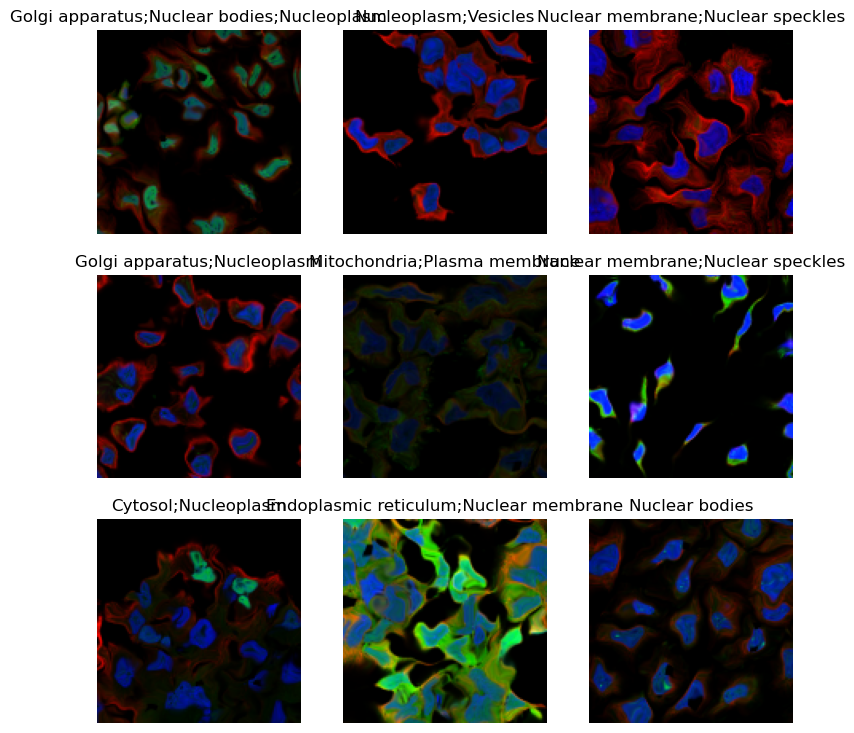

In [40]:
dls.show_batch(nrows=3, ncols=3)

In [41]:
len(dls.vocab) #Seems missing one of classes

18

## Add training loop.

https://docs.fast.ai/tutorial.vision.html#multi-label-classification 

In [42]:
f1_macro = F1ScoreMulti(thresh=0.5, average='macro')
f1_macro.name = 'F1(macro)'
f1_samples = F1ScoreMulti(thresh=0.5, average='samples')
f1_samples.name = 'F1(samples)'

learn = vision_learner(dls, resnet50, metrics=[partial(accuracy_multi, thresh=0.5), f1_macro, f1_samples])

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 59.2MB/s]


SuggestedLRs(valley=0.004365158267319202)

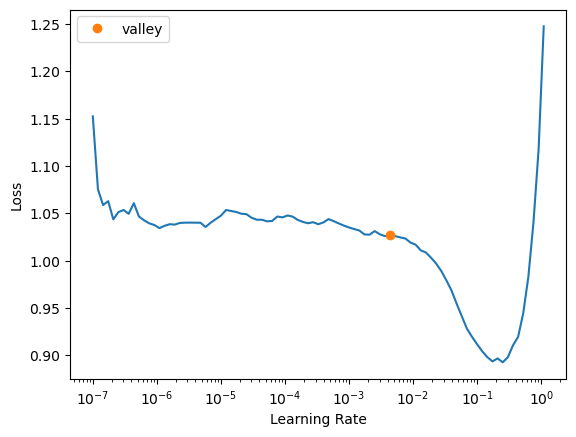

In [43]:
learn.lr_find()

In [44]:
learn.fine_tune(2, 1e-3)

epoch,train_loss,valid_loss,accuracy_multi,F1(macro),F1(samples),time
0,1.039501,0.888613,0.485232,0.167749,0.182286,00:58


epoch,train_loss,valid_loss,accuracy_multi,F1(macro),F1(samples),time
0,0.982080,0.883730,0.516878,0.176365,0.199234,00:58
1,0.954872,0.848580,0.515471,0.165229,0.178194,00:57


In [45]:
learn.fit_one_cycle(12, slice(1e-3, 1e-2))  #Training for more than 20 epochs

epoch,train_loss,valid_loss,accuracy_multi,F1(macro),F1(samples),time
0,0.913493,1.055429,0.509142,0.153220,0.171336,00:58
1,0.806390,2.737996,0.622363,0.151473,0.183337,00:58
2,0.614587,0.381870,0.883966,0.042667,0.086076,00:58
3,0.510986,0.379735,0.881857,0.038247,0.102954,00:58
4,0.453956,0.332296,0.896624,0.100735,0.278059,00:57
5,0.412731,0.275919,0.909283,0.069237,0.266667,00:58
6,0.378145,0.310107,0.903657,0.041033,0.178059,00:58
7,0.355022,0.338258,0.891702,0.080262,0.283544,00:58
8,0.334603,0.497522,0.902250,0.094674,0.267511,00:59
9,0.317446,0.291679,0.905063,0.072972,0.203376,00:59


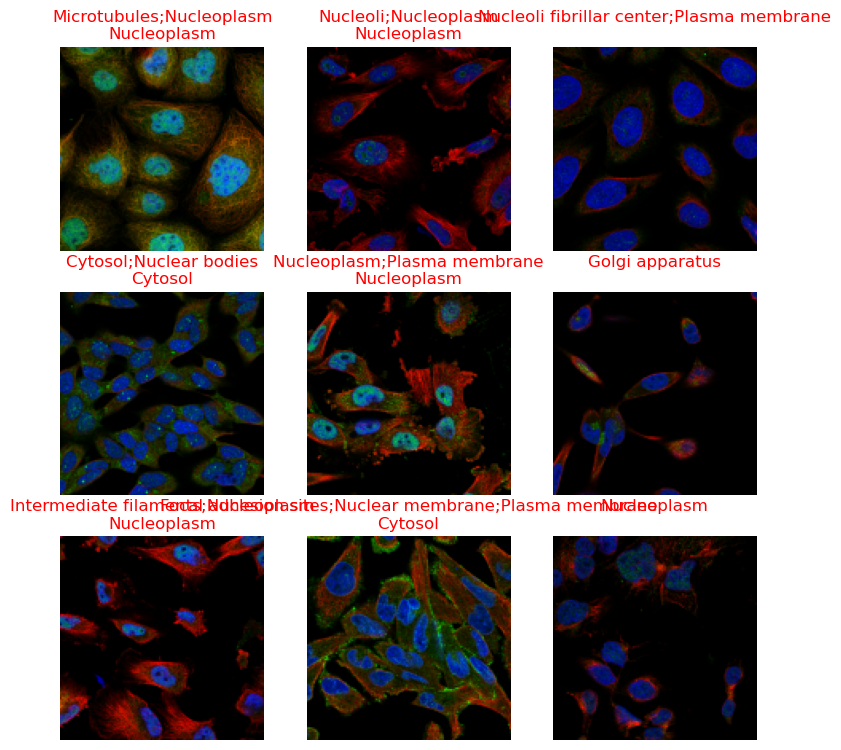

In [46]:
learn.show_results()

,target,predicted,probabilities,loss
0,Centrosome;Nuclear bodies;Nuclear membrane;Nucleoplasm,Nucleoplasm,"tensor([0.0027, 0.0135, 0.1223, 0.0114, 0.0226, 0.1302, 0.0101, 0.0020, 0.0228,\n 0.0033, 0.0733, 0.0434, 0.0182, 0.1005, 0.0295, 0.8776, 0.0381, 0.0019])",0.5959022045135498
1,Intermediate filaments;Mitochondria;Plasma membrane,,"tensor([0.0031, 0.0471, 0.3512, 0.1483, 0.0621, 0.0190, 0.0886, 0.0400, 0.0199,\n 0.0086, 0.0382, 0.2260, 0.0283, 0.0355, 0.0224, 0.4131, 0.1046, 0.0026])",0.5717573165893555
2,Centrosome;Nucleoli,Nucleoplasm,"tensor([0.0062, 0.0409, 0.3741, 0.0110, 0.0075, 0.0680, 0.0035, 0.0029, 0.0135,\n 0.0024, 0.1307, 0.0809, 0.1058, 0.1224, 0.0309, 0.7172, 0.0304, 0.0040])",0.4194364547729492
3,Cytosol;Plasma membrane,Nuclear membrane,"tensor([0.0024, 0.0264, 0.1896, 0.2780, 0.0224, 0.0126, 0.2227, 0.0239, 0.0112,\n 0.0026, 0.0115, 0.5780, 0.0413, 0.0235, 0.0108, 0.2260, 0.0230, 0.0034])",0.40708455443382263
4,Endoplasmic reticulum;Nucleoli fibrillar center,,"tensor([0.0031, 0.0321, 0.4222, 0.0972, 0.0751, 0.0385, 0.0135, 0.0240, 0.0148,\n 0.0122, 0.0684, 0.1702, 0.0241, 0.0520, 0.0401, 0.3138, 0.1723, 0.0022])",0.4009096324443817
5,Cytosol;Nuclear bodies;Nucleoplasm,,"tensor([0.0021, 0.0205, 0.2783, 0.2010, 0.1604, 0.0262, 0.0683, 0.0257, 0.0275,\n 0.0060, 0.0511, 0.1127, 0.0210, 0.0326, 0.0657, 0.1824, 0.3044, 0.0020])",0.396723210811615
6,Centrosome;Cytosol,Cytosol,"tensor([0.0014, 0.0054, 0.6532, 0.1733, 0.0090, 0.0248, 0.0366, 0.0378, 0.0147,\n 0.0046, 0.0210, 0.2254, 0.0430, 0.0191, 0.0116, 0.2189, 0.2349, 0.0015])",0.3793366551399231
7,Golgi apparatus;Nuclear membrane,Nucleoplasm,"tensor([0.0115, 0.0474, 0.1320, 0.0356, 0.0200, 0.0427, 0.0335, 0.0040, 0.0240,\n 0.0021, 0.1538, 0.1325, 0.1149, 0.1233, 0.0394, 0.5595, 0.0286, 0.0091])",0.3787073493003845
8,Nuclear speckles;Plasma membrane,,"tensor([0.0010, 0.0101, 0.4172, 0.0671, 0.1463, 0.0259, 0.0304, 0.0163, 0.0201,\n 0.0108, 0.0273, 0.0463, 0.0126, 0.0179, 0.0768, 0.3947, 0.4365, 0.0009])",0.3756318986415863


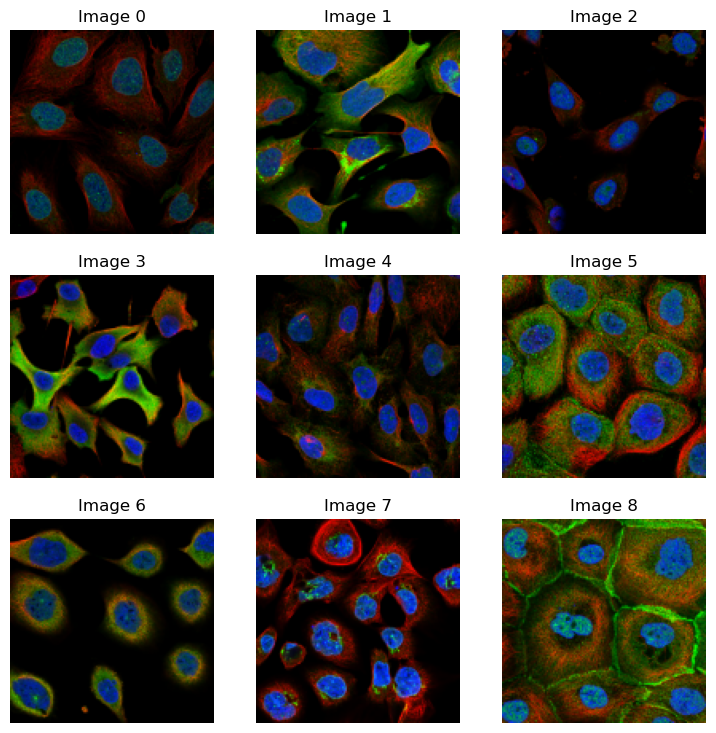

In [47]:
interp = Interpretation.from_learner(learn)
interp.plot_top_losses(9)

## Move the entire pipe line to GCP